# NEAR-STAKEWAR: NEAR DATA SCIENCE

Below you can find set of tools for Mainnet validator statistics analysis

In [1]:
import argparse
import sys
import requests
import json
import os
from string import Template
import argparse
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [30]:
#last_epoch_stat_block = 73669889
rpc = 'https://archival-rpc.mainnet.near.org'
step = 43200 # epoch length
first_block_validator_data = 65505089 # first block where validator data is available

def get_current_block():
    payload = {
          "jsonrpc": "2.0",
          "id": "dontcare",
          "method": "block",
          "params": {
            "finality": "final"
          }
        }
    response = requests.post(rpc, json=payload).json()
    return response["result"]["header"]['height']

def get_validators_info(block):
    payload = {
        "method": "validators",
        "params": [block],
        "jsonrpc": "2.0",
        "id": "dontcare",
    }
    response = requests.post(rpc, json=payload).json()

    if "error" in response:
        if response["error"]["cause"]["name"] in ["UNKNOWN_BLOCK","VALIDATOR_INFO_UNAVAILABLE","UNKNOWN_EPOCH"]:
            return
    return response

def get_df_validators_info():
    validators_info = pd.DataFrame()
    validators_kickout_info = pd.DataFrame()
    curent_block = get_current_block()
    last_block_validator_data = 65505089 + ((73698717 - 65505089) // 43200) * 43200
    counter = 0
    for block in range(first_block_validator_data, last_block_validator_data + 43200, 43200):
    #for block in range(first_block_validator_data, first_block_validator_data + 3 * 43200, 43200):
        result = get_validators_info(block)
        counter = counter + 1
        if result == None:
            print('№: ', counter, 'Block :', block, 'Bad response RPC')
            continue
        validators = result["result"]["current_validators"]
        print('№: ', counter, 'Block :', block, 'OK', 'validators :', len(validators))
        kickout = result["result"]["prev_epoch_kickout"]
        df_validators = pd.DataFrame(validators)
        df_validators['block'] = block
        validators_info = validators_info.append(df_validators)
        df_kickout = pd.DataFrame(kickout)
        df_kickout['block'] = block
        validators_kickout_info = validators_kickout_info.append(df_kickout)
    return validators_info, validators_kickout_info

def get_lifecycle_worst_n_block_produce_validator(validators_info, n):
    validators_info_df = validators_info.copy()
    validator = validators_info_df.groupby(['account_id']).sum()
    validator['blocks_success'] = validator['num_produced_blocks'] / validator['num_expected_blocks']
    return validator.sort_values(['blocks_success']).head(n)

def get_last_n_epoch_worst_block_produce_validator(validators_info, n):
    validators_info_df = validators_info.copy()
    lowest_block = validators_info_df.groupby(['block']).sum().sort_values(by='block', ascending=False).head(n).iloc[-1:].index.to_list()[0]
    validators_set = validators_info_df[validators_info['block']>=lowest_block]
    return get_lifecycle_worst_n_block_produce_validator(validators_set, 1)

def get_n_oldest_validators(validators_info, n):
    return  validators_info.groupby('account_id')['account_id'].count().nlargest(n)

def get_unique_validators(validators_info):
    return pd.unique(validators_info['account_id'])

def validator_block_produce_chart(validators_info, validator):
    sns.set_style("darkgrid")
    plt.subplots(figsize=(15, 10))
    validator_info_df = validators_info[validators_info['account_id'] == validator].copy()
    validator_info_df['blocks_success'] = validator_info_df['num_produced_blocks'] / validator_info_df['num_expected_blocks']
    validator_info_df['chunks_success'] = validator_info_df['num_produced_chunks'] / validator_info_df['num_expected_chunks']
    plt.plot(validator_info_df['block'] , validator_info_df['blocks_success'] , label='Block production' )
    plt.plot(validator_info_df['block'], validator_info_df['chunks_success'], label='Chunk production' )
    plt.legend()
    plt.ylabel('success, %', fontsize=18)
    plt.xlabel('epoch, last block', fontsize=16)
    plt.title('Validator performance')
    #plt.figure(figsize=(3, 3))
    plt.show()
    #sns.lineplot(data=validator_info_df, x="block", y="blocks_success")

In [3]:
validators_info, validators_kickout_info = get_df_validators_info()

№:  1 Block : 65505089 Bad response RPC
№:  2 Block : 65548289 OK validators : 100
№:  3 Block : 65591489 OK validators : 100
№:  4 Block : 65634689 OK validators : 100
№:  5 Block : 65677889 OK validators : 100
№:  6 Block : 65721089 OK validators : 100
№:  7 Block : 65764289 OK validators : 100
№:  8 Block : 65807489 OK validators : 100
№:  9 Block : 65850689 OK validators : 100
№:  10 Block : 65893889 OK validators : 100
№:  11 Block : 65937089 OK validators : 100
№:  12 Block : 65980289 OK validators : 100
№:  13 Block : 66023489 OK validators : 100
№:  14 Block : 66066689 OK validators : 100
№:  15 Block : 66109889 OK validators : 100
№:  16 Block : 66153089 OK validators : 100
№:  17 Block : 66196289 OK validators : 100
№:  18 Block : 66239489 OK validators : 100
№:  19 Block : 66282689 OK validators : 100
№:  20 Block : 66325889 OK validators : 100
№:  21 Block : 66369089 OK validators : 100
№:  22 Block : 66412289 OK validators : 100
№:  23 Block : 66455489 OK validators : 100


## Get the N worst block producers since genesis

In [4]:
get_lifecycle_worst_n_block_produce_validator(validators_info, 10)

,is_slashed,num_expected_blocks,num_expected_chunks,num_produced_blocks,num_produced_chunks,block,blocks_success
account_id,,,,,,,
jumbo_exchange.pool.near,False,1454,5792,1439,5752,5210097675,0.989684
binancestaking.poolv1.near,False,109,436,108,434,469292423,0.990826
restake.poolv1.near,False,1545,6164,1536,6128,6487844188,0.994175
yes_protocol1.poolv1.near,False,11259,44812,11209,44768,661473801,0.995559
steak.poolv1.near,False,13687,54624,13629,54460,12724120887,0.995762
stakesstone.poolv1.near,False,3908,15576,3892,15528,12620024309,0.995906
anchikovproduction.poolv1.near,False,1383,5528,1378,5520,7391234923,0.996385
stakely_io.poolv1.near,False,3690,14720,3678,14680,12355728242,0.996748
sparkpool.poolv1.near,False,4989,19908,4973,19884,12598208309,0.996793


## Get the worst block producers for last N epochs

In [8]:
get_last_n_epoch_worst_block_produce_validator(validators_info, 10)

,is_slashed,num_expected_blocks,num_expected_chunks,num_produced_blocks,num_produced_chunks,block,blocks_success
account_id,,,,,,,
genesislab.poolv1.near,False,99,396,96,394,293383556,0.969697


## Get the N oldest validators, who validates the most epochs

In [9]:
get_n_oldest_validators(validators_info, 10)

account_id
08investinwomen_runbybisontrails.poolv1.near    189
accomplice.poolv1.near                          189
anonymous.poolv1.near                           189
appload.poolv1.near                             189
astro-stakers.poolv1.near                       189
aurora.pool.near                                189
baziliknear.poolv1.near                         189
binancenode1.poolv1.near                        189
bisontrails.poolv1.near                         189
blockdaemon.poolv1.near                         189
Name: account_id, dtype: int64

## Get the LIST of unique validator names since genesis

In [10]:
get_unique_validators(validators_info)

array(['staked.poolv1.near', 'astro-stakers.poolv1.near',
       'bzam6yjpnfnxsdmjf6pw.poolv1.near', 'aurora.pool.near',
       'bisontrails.poolv1.near', 'dragonfly.poolv1.near',
       'foundry.poolv1.near', 'binancenode1.poolv1.near',
       'zavodil.poolv1.near', 'epic.poolv1.near',
       'valisaurus-dex.poolv1.near', 'finoa.poolv1.near',
       'magic.poolv1.near', 'future_is_near.poolv1.near',
       'stake1.poolv1.near', 'rekt.poolv1.near', 'electric.poolv1.near',
       'nearcrowd.poolv1.near', 'blockdaemon.poolv1.near',
       'anonymous.poolv1.near', 'd1.poolv1.near',
       '08investinwomen_runbybisontrails.poolv1.near',
       'chorusone.poolv1.near', 'figment.poolv1.near',
       'abl_pool.poolv1.near', 'accomplice.poolv1.near',
       'dokiacapital.poolv1.near', 'legends.poolv1.near',
       'hb436_pool.poolv1.near', 'continue.poolv1.near',
       'openshards.poolv1.near', 'ideocolabventures.poolv1.near',
       'northernlights.poolv1.near', 'nearfans.poolv1.near',
     

## Chart validator block_success by epoch

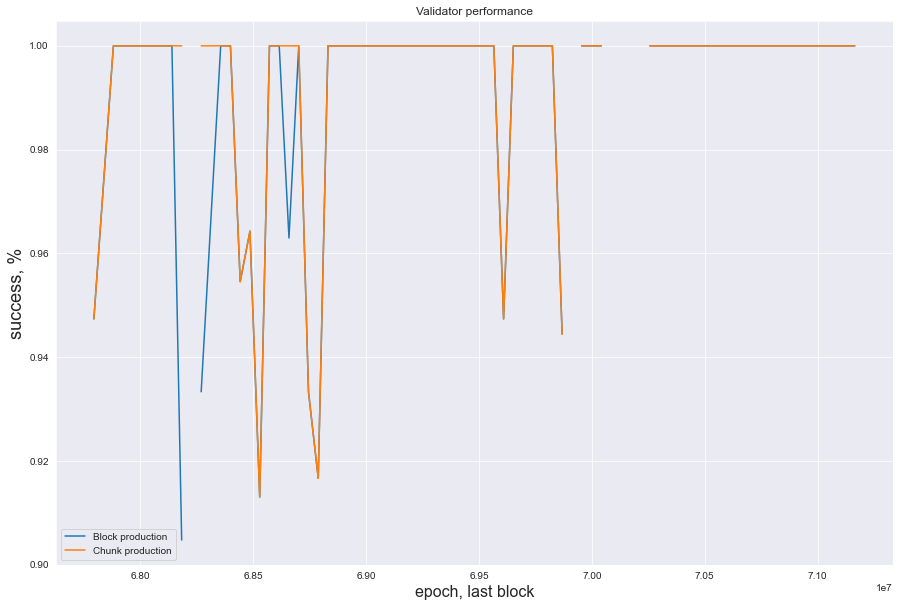

In [31]:
validator_block_produce_chart(validators_info, 'jumbo_exchange.pool.near')